In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import lightgbm as lgb
from xgboost import XGBRegressor

In [35]:
# Load dataset
df = pd.read_csv("train.csv")
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)


In [36]:
# Convert date columns
df["Order Date"] = pd.to_datetime(df["Order Date"], format="%d/%m/%Y")
df["Ship Date"] = pd.to_datetime(df["Ship Date"], format="%d/%m/%Y")


In [37]:
# Extract additional date features
df["Order Year"] = df["Order Date"].dt.year
df["Order Month"] = df["Order Date"].dt.month
df["Ship Year"] = df["Ship Date"].dt.year
df["Ship Month"] = df["Ship Date"].dt.month

In [38]:
# Fill missing postal codes
df["Postal Code"] = df["Postal Code"].fillna(50840)


In [39]:
# Exploratory Data Analysis (EDA)
print(df.describe())
print(df.isnull().sum())


            Row ID                     Order Date  \
count  9789.000000                           9789   
mean   4896.705588  2017-05-01 02:51:57.866993664   
min       1.000000            2015-01-03 00:00:00   
25%    2449.000000            2016-05-23 00:00:00   
50%    4896.000000            2017-06-26 00:00:00   
75%    7344.000000            2018-05-15 00:00:00   
max    9800.000000            2018-12-30 00:00:00   
std    2827.486899                            NaN   

                           Ship Date   Postal Code         Sales   Order Year  \
count                           9789   9789.000000   9789.000000  9789.000000   
mean   2017-05-05 01:56:03.898253056  55273.322403    230.116193  2016.723567   
min              2015-01-07 00:00:00   1040.000000      0.444000  2015.000000   
25%              2016-05-27 00:00:00  23223.000000     17.248000  2016.000000   
50%              2017-06-29 00:00:00  58103.000000     54.384000  2017.000000   
75%              2018-05-19 00:00:00

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17748\3747500839.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




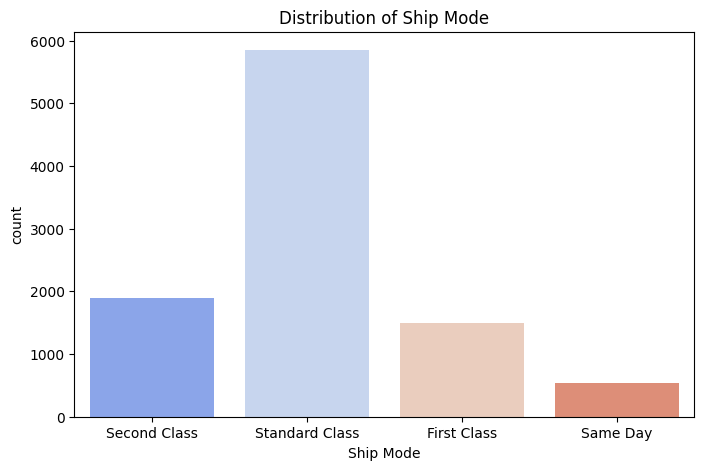

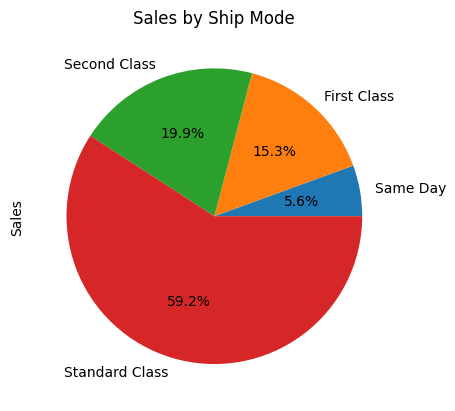

In [40]:
# 📊 **Visualizations**
## 1️⃣ **Ship Mode Distribution**
plt.figure(figsize=(8, 5))
sns.countplot(x='Ship Mode', data=df, palette='coolwarm')
plt.title("Distribution of Ship Mode")
plt.show()

df.groupby(["Ship Mode"])["Sales"].sum().sort_values().plot(kind="pie", autopct="%1.1f%%")
plt.title("Sales by Ship Mode")
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17748\1737857945.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




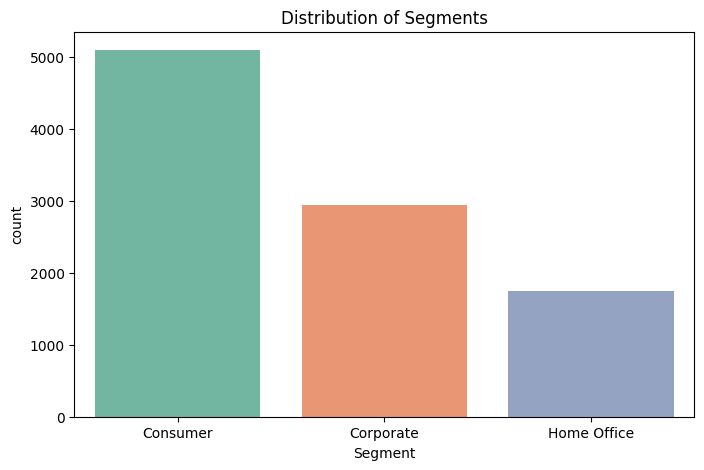

In [41]:
## 2️⃣ **Segment Distribution**
plt.figure(figsize=(8, 5))
sns.countplot(x='Segment', data=df, palette='Set2')
plt.title('Distribution of Segments')
plt.show()

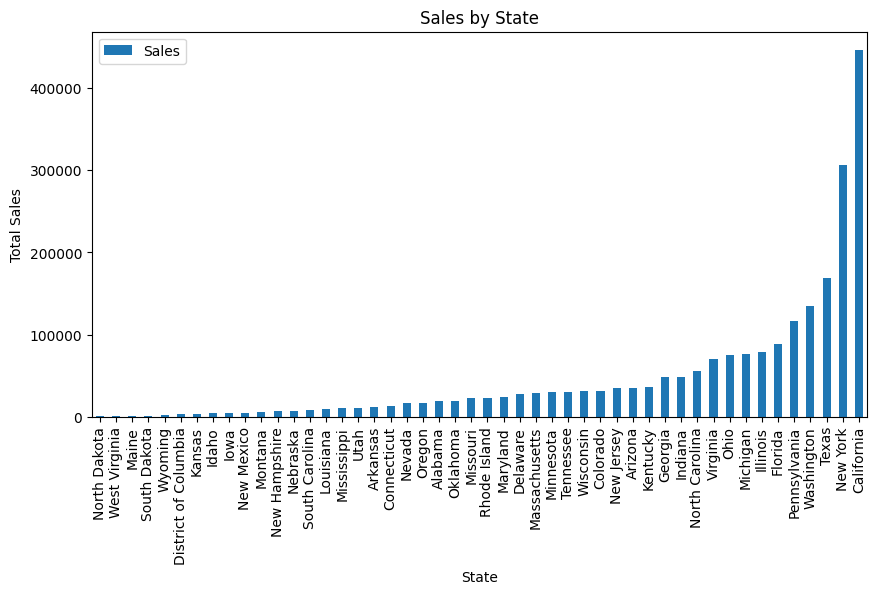

In [42]:
## 3️⃣ **Sales by State**
df.groupby(["State"])[["Sales"]].sum().sort_values("Sales").plot(kind="bar", figsize=(10, 5))
plt.title("Sales by State")
plt.xlabel("State")
plt.ylabel("Total Sales")
plt.xticks(rotation=90)
plt.show()

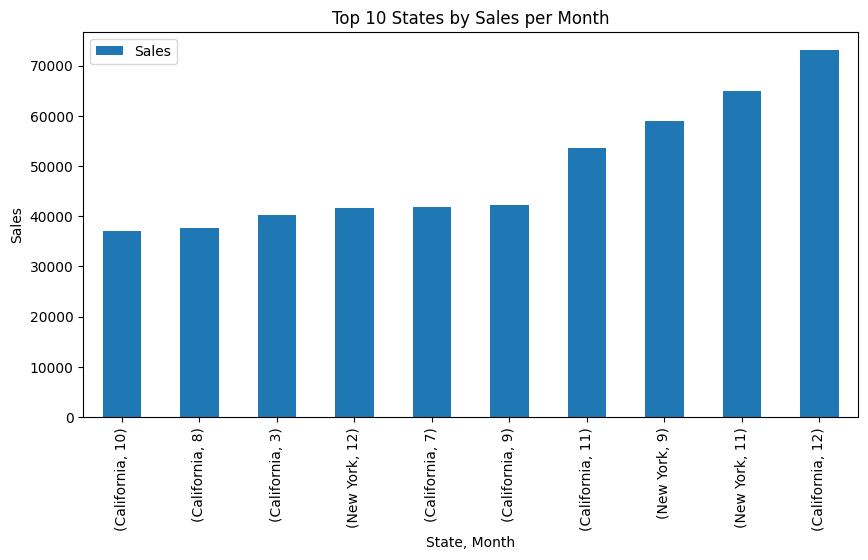

In [43]:
## 4️⃣ **Top 10 States by Sales Per Month**
top_10 = df.groupby(["State", "Order Month"])[["Sales"]].sum().sort_values("Sales").tail(10)
top_10.plot(kind="bar", figsize=(10, 5))
plt.title("Top 10 States by Sales per Month")
plt.xlabel("State, Month")
plt.ylabel("Sales")
plt.show()


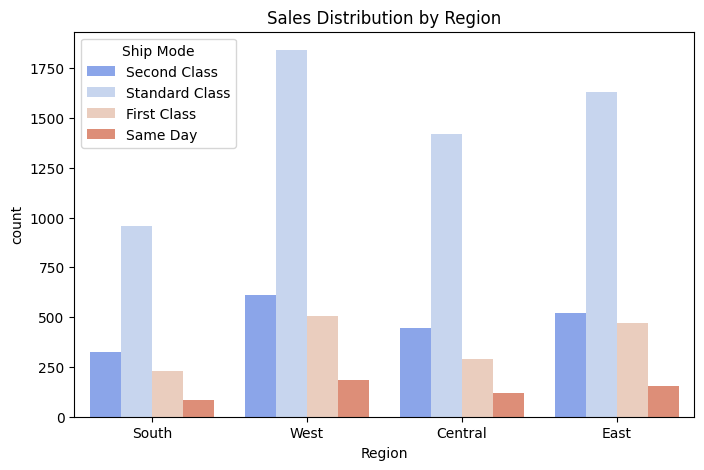

In [44]:
## 5️⃣ **Sales by Region**
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Region"], hue=df["Ship Mode"], palette="coolwarm")
plt.title("Sales Distribution by Region")
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17748\2394309265.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




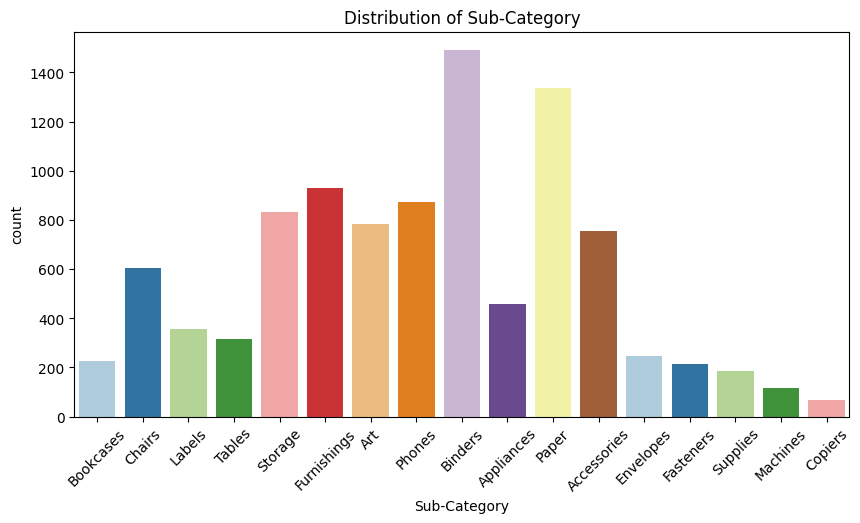

In [45]:
## 6️⃣ **Sub-Category Distribution**
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x=df["Sub-Category"], palette="Paired")
plt.xticks(rotation=45)
plt.title("Distribution of Sub-Category")
plt.show()

In [46]:
## 7️⃣ **Sales by Sub-Category (Scatter Plot)**
fig_scatter = px.scatter(df, x="Sub-Category", y="Sales", title="Sales by Sub-Category",
                         labels={"Sub-Category": "Sub-Category", "Sales": "Sales Amount"})
fig_scatter.show()

fig_scatter = px.scatter(df, x="Sub-Category", y="Sales", color="Category", title="Sub-Category Sales by Category")
fig_scatter.show()

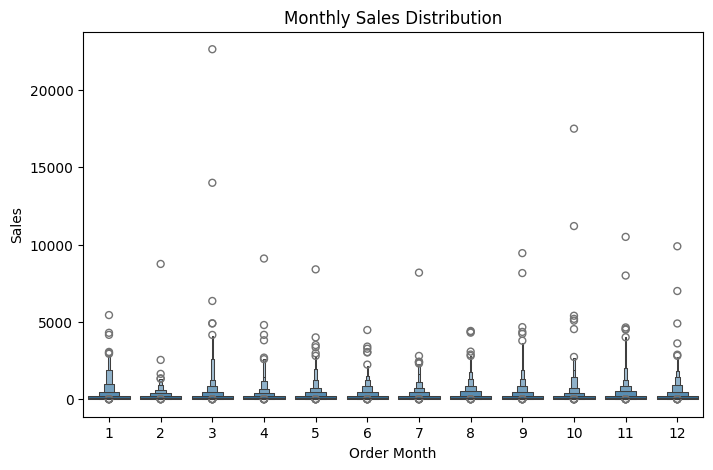

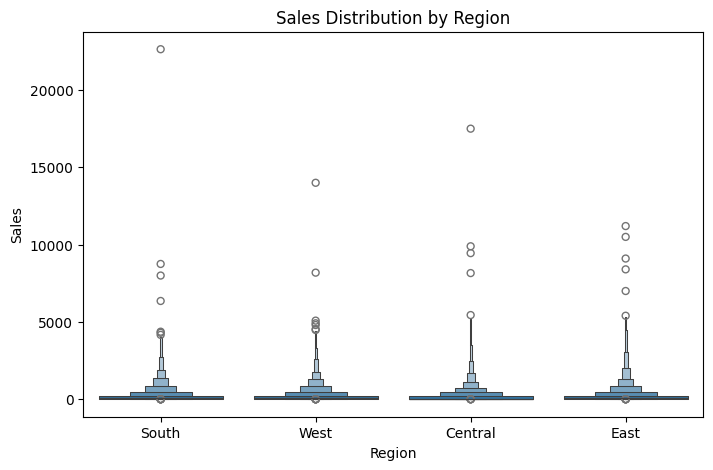

In [47]:
## 8️⃣ **Boxenplots**
plt.figure(figsize=(8, 5))
sns.boxenplot(x='Order Month', y='Sales', data=df)
plt.title("Monthly Sales Distribution")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxenplot(x='Region', y="Sales", data=df)
plt.title("Sales Distribution by Region")
plt.show()

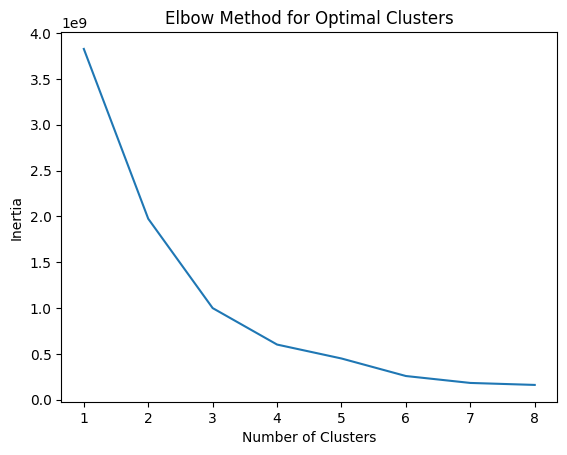

In [48]:
# 📈 **Machine Learning Models**
## 🔹 **Clustering using K-Means**
X = df[['Order Year', 'Order Month', 'Sales']]
kmeans = []
for i in range(1, 9):
    model = KMeans(n_clusters=i, random_state=42)
    model.fit(X)
    kmeans.append(model.inertia_)

plt.plot(range(1, 9), kmeans)
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [49]:
## 🔹 **Training Linear Regression Model**
X = df[['Order Year', 'Order Month']]
y = df['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("Linear Regression Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R-squared: {r2:.2f}")

Linear Regression Performance:
RMSE: 623.69
MAE: 273.05
R-squared: -0.00


In [50]:
## 🔹 **Training Random Forest Model**
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

rmse_rf = sqrt(mean_squared_error(y_test, rf_preds))
mae_rf = mean_absolute_error(y_test, rf_preds)
r2_rf = r2_score(y_test, rf_preds)

print("Random Forest Performance:")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R-squared: {r2_rf:.2f}")

Random Forest Performance:
RMSE: 626.22
MAE: 274.90
R-squared: -0.01


In [51]:
## 🔹 **Training LightGBM Model**
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'learning_rate': 0.03,
    'max_depth': 6,
    'num_leaves': 31,
    'objective': 'regression',
    'metric': 'mse',
    'force_col_wise': True
}

lgb_model = lgb.train(params, train_data, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=10)])
lgb_preds = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

rmse_lgb = sqrt(mean_squared_error(y_test, lgb_preds))
mae_lgb = mean_absolute_error(y_test, lgb_preds)
r2_lgb = r2_score(y_test, lgb_preds)

print("LightGBM Performance:")
print(f"RMSE: {rmse_lgb:.2f}")
print(f"MAE: {mae_lgb:.2f}")
print(f"R-squared: {r2_lgb:.2f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 6852, number of used features: 2
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 227.996523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [52]:
## 🔹 **Training XGBoost Model**
xgb_model = XGBRegressor(learning_rate=0.03, max_depth=1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

rmse_xgb = sqrt(mean_squared_error(y_test, xgb_preds))
r2_xgb = r2_score(y_test, xgb_preds)

print("XGBoost Performance:")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R-squared: {r2_xgb:.2f}")



XGBoost Performance:
RMSE: 623.48
R-squared: -0.00


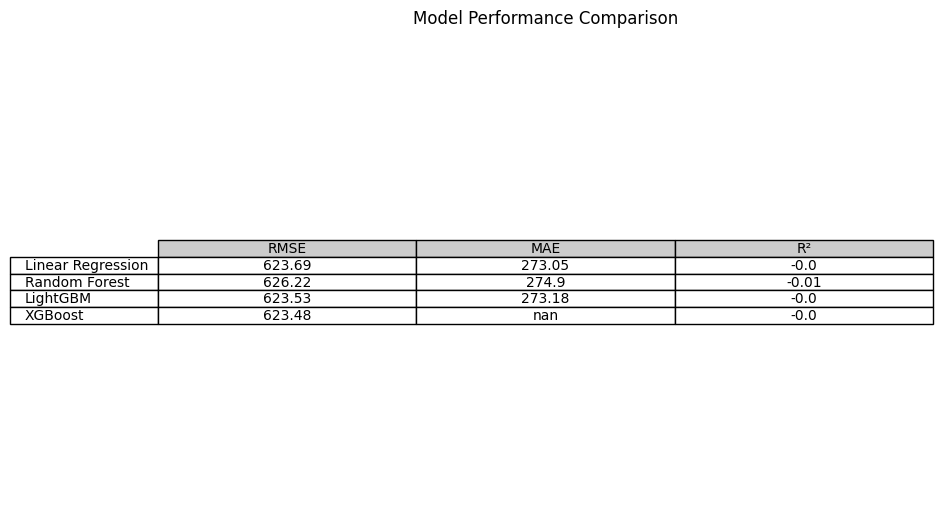

In [55]:
# Create comparison dataframe
results = [
    {'Model': 'Linear Regression', 
     'RMSE': rmse, 
     'MAE': mae, 
     'R²': r2},
    
    {'Model': 'Random Forest', 
     'RMSE': rmse_rf, 
     'MAE': mae_rf, 
     'R²': r2_rf},
    
    {'Model': 'LightGBM', 
     'RMSE': rmse_lgb, 
     'MAE': mae_lgb, 
     'R²': r2_lgb},
    
    {'Model': 'XGBoost', 
     'RMSE': rmse_xgb, 
     'MAE': 'N/A',  # Add MAE calculation if available
     'R²': r2_xgb}
]

results_df = pd.DataFrame(results).set_index('Model')

# Format numeric columns
numeric_cols = ['RMSE', 'MAE', 'R²']
results_df[numeric_cols] = results_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Create styled table
styled_table = (results_df.style
                .format({'RMSE': '{:.2f}', 'MAE': '{:.2f}', 'R²': '{:.2f}'})
                .background_gradient(cmap='Blues', subset=['R²'])
                .set_caption('Machine Learning Models Performance Comparison'))

# Display table
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=results_df.values.round(2),
          colLabels=results_df.columns,
          rowLabels=results_df.index,
          cellLoc='center',
          loc='center',
          colColours=['#cccccc']*3)
plt.title('Model Performance Comparison', pad=20)
plt.show()

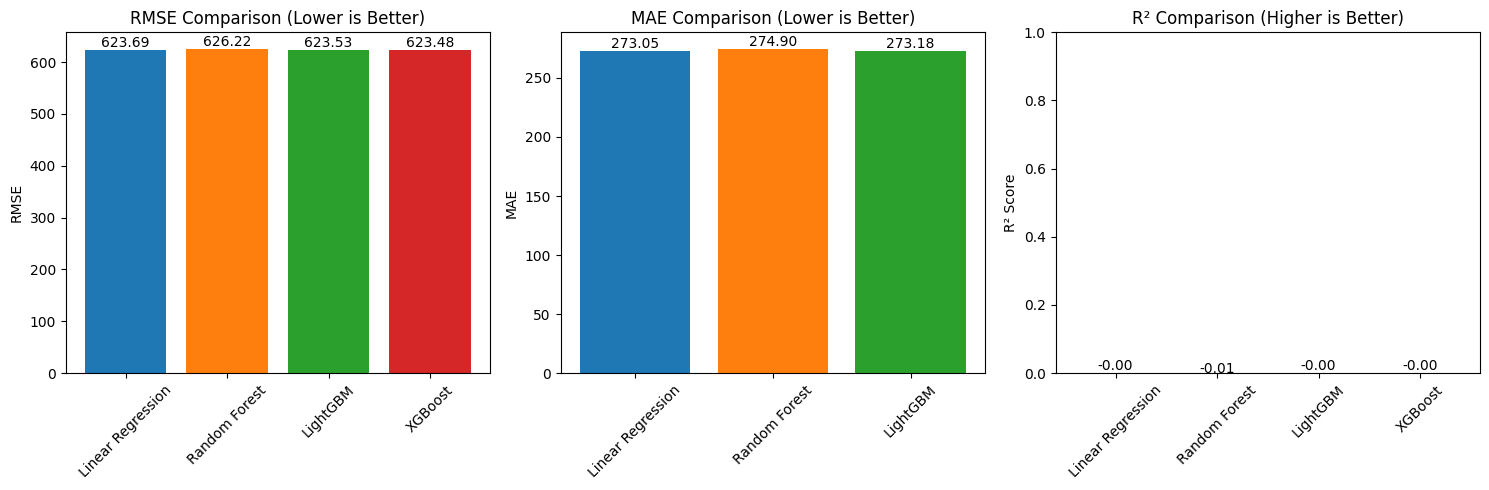

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Create dataframe from results
models = ['Linear Regression', 'Random Forest', 'LightGBM', 'XGBoost']
metrics = {
    'RMSE': [rmse, rmse_rf, rmse_lgb, rmse_xgb],
    'MAE': [mae, mae_rf, mae_lgb, np.nan],  # NaN for XGBoost MAE
    'R²': [r2, r2_rf, r2_lgb, r2_xgb]
}

# Create figure with subplots
plt.figure(figsize=(15, 5))

# 1. RMSE Comparison
plt.subplot(1, 3, 1)
bars = plt.bar(models, metrics['RMSE'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('RMSE Comparison (Lower is Better)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom')

# 2. MAE Comparison
plt.subplot(1, 3, 2)
bars = plt.bar(models[:3], metrics['MAE'][:3], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('MAE Comparison (Lower is Better)')
plt.ylabel('MAE')
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom')

# 3. R² Comparison
plt.subplot(1, 3, 3)
bars = plt.bar(models, metrics['R²'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('R² Comparison (Higher is Better)')
plt.ylabel('R² Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

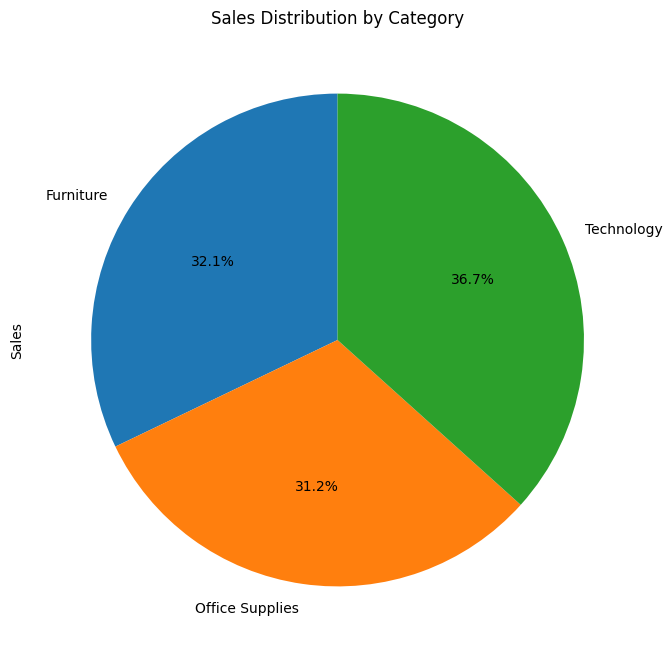

In [53]:
## 🔹 **Visualizing Sales Distribution**
plt.figure(figsize=(8, 8))
df.groupby("Category")["Sales"].sum().plot(kind="pie", autopct="%1.1f%%", startangle=90)
plt.title("Sales Distribution by Category")
plt.show()